In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [92]:
!pip install torchmetrics

  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/fa/86/264f2a30d7cdd2f7e93dcca840b588c002e1631d4dfc1fd6ffa4bb497d23/torchmetrics-1.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.8.0 from https://files.pythonhosted.org/packages/46/ee/8641eeb6a062f383b7d6875604e1f3f83bd2c93a0b4dbcabd3150b32de6e/lightning_utilities-0.9.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 5.2 MB/s eta 0:00:00m eta 0:00:010:01:01


In [93]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics

In [3]:
# Load dataset
DATA_DIR_PATH = "dataset"
DATA_PATH = os.path.join(DATA_DIR_PATH, 'animal-faces')
DATA_URL = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces/download?datasetVersionNumber=1'
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [ ]:
# class AnimalfaceDataset(Dataset):
#     def __init__(self, type='train', transform=None, label_dict = {"dog":0, "cat":1, "wild":2}) -> None:
#         self.transform = transform
#         # self.root_dir specifies weather you are at afhq/train or afhq/val directory
#         self.label_dict = label_dict
#         self.root_dir = os.path.join(DATA_PATH, type)
#         assert os.path.exists(self.root_dir), "Check for the dataset, it is not where it should be. If not present, you can download it by clicking above DATA_URL"
#         subdir = os.listdir(self.root_dir)
#         self.image_names = []
        
#         for category in subdir:
#             subdir_path = os.path.join(self.root_dir, category)
#             self.image_names+=os.listdir(subdir_path)
        
    
#     def __getitem__(self, idx):
#         # Get the path to the image 
#         img_name = self.image_names[idx]
#         label = self.label_dict[img_name.split("_")[1]]
#         img_path = os.path.join(self.root_dir, img_name.split("_")[1], img_name)
#         # Load image and convert it to RGB
#         img = Image.open(img_path).convert('RGB')
#         # Apply transformations to the image
#         if self.transform:
#             img = self.transform(img)
#         return img, label
    
#     def __len__(self):
#         return len(self.image_names)
    

In [4]:
class AnimalfaceDataset(Dataset):
    def __init__(self, transform, type='train', label_dict = {"dog":0, "cat":1, "wild":2}) -> None:
        self.transform = transform
        # self.root_dir specifies weather you are at afhq/train or afhq/val directory
        self.label_dict = label_dict
        self.root_dir = os.path.join(DATA_PATH, type)
        assert os.path.exists(self.root_dir), "Check for the dataset, it is not where it should be. If not present, you can download it by clicking above DATA_URL"
        subdir = os.listdir(self.root_dir)
        self.image_names = []
        
        for category in subdir:
            subdir_path = os.path.join(self.root_dir, category)
            self.image_names+=os.listdir(subdir_path)
        

        self.img_arr = torch.zeros((len(self.image_names), 3, 128 ,128))
        self.labels = torch.zeros(len(self.image_names))
            
        for i,img_name in enumerate(tqdm(self.image_names)):
            label = self.label_dict[img_name.split("_")[1]]
            img_path = os.path.join(self.root_dir, img_name.split("_")[1], img_name)
            # Load image and convert it to RGB
            img = Image.open(img_path).convert('RGB')
            # Apply transformations to the image
            img = self.transform(img)
            self.img_arr[i] = img
            self.labels[i] = label
            
    def __getitem__(self, idx):
        return self.img_arr[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.image_names)
    

In [5]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128))])
train_data = AnimalfaceDataset(transform=transform)


  0%|                                                                                      | 0/14630 [00:00<?, ?it/s]/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████| 14630/14630 [01:40<00:00, 145.34it/s]


In [6]:
val_data = AnimalfaceDataset(transform=transform, type="val")


100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 145.05it/s]


In [8]:
BATCH_SIZE = 2048
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([2048, 3, 128, 128]), torch.Size([2048]))

In [9]:
class Encoder(nn.Module):
    def __init__(self, conv_op_size = (32,6,6), enc_op_size=1024):
        super(Encoder, self).__init__()
        self.conv_layer = nn.Sequential(
                nn.Conv2d(3, 8, 7, stride=2),
                nn.ReLU(True),
                nn.Conv2d(8, 16, 5, stride=2),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2),
                nn.ReLU(True),
                nn.Conv2d(32, 32, 3, stride=2),
                nn.ReLU(True)
        )
        
        self.liner_layer = nn.Sequential(nn.Linear(conv_op_size[0]*conv_op_size[1]*conv_op_size[2], enc_op_size))
        
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.flatten(start_dim=1)
        x = self.liner_layer(x)
        return x
    
e = Encoder()
eo = e(x)
eo.shape

torch.Size([2048, 1024])

In [47]:
class Decoder(nn.Module):
    def __init__(self, conv_op_size = (32,14,14), dec_ip_size=1024):
        super(Decoder, self).__init__()
        self.conv_layer = nn.Sequential(            
            nn.ConvTranspose2d(32, 32, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 7, stride=2, output_padding=1)
        )
        
        self.liner_layer = nn.Sequential(nn.Linear(dec_ip_size, conv_op_size[0]*conv_op_size[1]*conv_op_size[2]))
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=conv_op_size)
        
        
    def forward(self, x):
        x = self.liner_layer(x)
        x = self.unflatten(x)
        x = self.conv_layer(x)
        x - torch.sigmoid(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, feature_size=256, conv_ip_size=(32, 6, 6)):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(enc_op_size=feature_size, conv_op_size=conv_ip_size)
        self.decoder = Decoder(dec_ip_size=feature_size, conv_op_size=conv_ip_size)
    
    def forward(self,x):
        enc = self.encoder(x)
        x = self.decoder(enc)
        return x, enc

ae = AutoEncoder().to(device)
op, enc = ae(x.to(device))
print(op.shape, enc.shape)

summary(ae, (3,128,128), device="cuda")

torch.Size([1500, 3, 128, 128]) torch.Size([1500, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 61, 61]           1,184
              ReLU-2            [-1, 8, 61, 61]               0
            Conv2d-3           [-1, 16, 29, 29]           3,216
       BatchNorm2d-4           [-1, 16, 29, 29]              32
              ReLU-5           [-1, 16, 29, 29]               0
            Conv2d-6           [-1, 32, 14, 14]           4,640
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8             [-1, 32, 6, 6]           9,248
              ReLU-9             [-1, 32, 6, 6]               0
           Linear-10                  [-1, 256]         295,168
          Encoder-11                  [-1, 256]               0
           Linear-12                 [-1, 1152]         296,064
        Unflatten-13             [-1, 32, 6, 6]

In [48]:
show_img = lambda x: plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

In [49]:
n_epochs = 100
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
losses = []
val_losses = []
for epoch in range(n_epochs):
    ae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc = ae(X) # [B, feature_size]
        loss = loss_fn(X, X_hat)
        loss.backward()
        optim.step()

        tqdm_obj.set_description_str(f"Loss {loss}")
        if i%5 == 0:
            losses.append(loss.detach().to(cpu_device))
    
    with torch.no_grad(): # mandatory to write
        ae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc = ae(X) # [B, feature_size]
            val_loss = loss_fn(X, X_hat)

            tqdm_obj.set_description_str(f"Val Loss {val_loss}")
            if i%5 == 0:
                val_losses.append(val_loss.detach().to(cpu_device))
                

Loss 0.02743714489042759: 100%|████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.00it/s]


Val Loss 0.024516921490430832: 100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Val Loss 0.023669643327593803: 100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s]


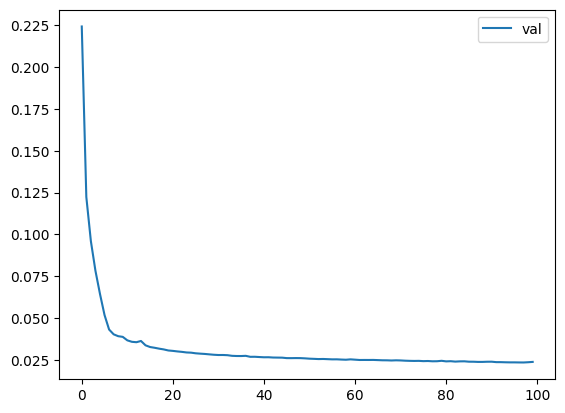

In [50]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
# plt.plot(to_cpu(losses), label="train")
plt.plot(to_cpu(val_losses), label="val")
plt.legend()

In [57]:
x, y = next(iter(val_loader))

In [58]:
x_hat, enc = ae(x.to(device))

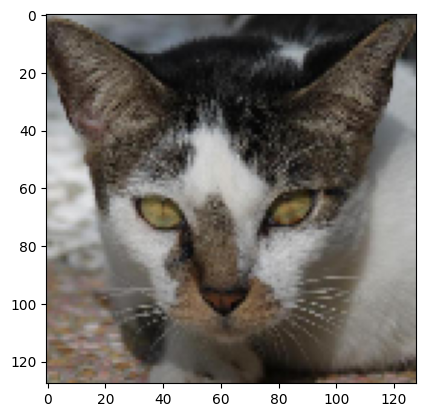

In [59]:
show_img(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


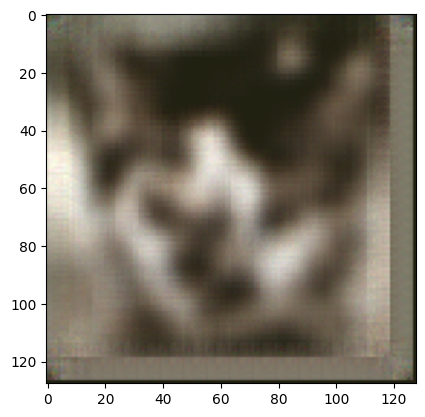

In [60]:
show_img(x_hat)

## Classification

In [61]:
dataset = train_data
dataloader = train_loader
latents = torch.zeros(len(v), 256)

In [63]:
temp = []
for X,y in tqdm(train_loader):
    X = X.to(device)
    with torch.no_grad():
        ae.eval()
        _, enc = ae(X)
        temp.append(enc)

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.37it/s]


In [68]:
temp[-1].shape

torch.Size([294, 256])

In [72]:
latents = torch.cat(temp)
latents.shape

torch.Size([14630, 256])

In [88]:
latent_data_loader = DataLoader(list(zip(latents, train_data.labels)), batch_size=2048)

In [85]:
class Classifier(nn.Module):
    def __init__(self, ip_size=256, n_classes=3):
        super(Classifier, self).__init__()        
        self.liner_layer = nn.Sequential(nn.Linear(ip_size, 128), nn.ReLU(), nn.Linear(128, n_classes))
        
        
    def forward(self, x):
        logits = self.liner_layer(x)
        y_log_probs = F.log_softmax(logits, dim=-1)
        y_pred = torch.argmax(y_log_probs, dim=-1)
        return logits, y_log_probs, y_pred
    
cl = Classifier().to(device)

In [89]:
y_preds = []
y_probs = []
for lat, y in latent_data_loader:
    logits, y_prob, y_pred = cl(lat)
    y_preds.append(y_pred)
    y_probs.append(y_prob)

In [99]:
y_pred = torch.cat(y_preds).to(cpu_device)
y_pred

tensor([1, 1, 1,  ..., 2, 1, 2])

In [103]:
torch.sum(y_pred == train_data.labels)/len(y_pred)

tensor(0.3447)